In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
hep.set_style(hep.styles.CMS)

In [3]:
NUM_CHAMBERS = 36

In [4]:
def plot_fill_between(data, label, color, ax=None):
    if ax is None:
        ax = plt.gca()

    gby = data.groupby('chamber')
    
    x = np.arange(1, 37)
    allowed_chambers = data.chamber.unique()
    
    def insert_pad(y):
        return np.array([y.loc[chamber] if chamber in allowed_chambers else np.nan for chamber in x])

    y = insert_pad(gby.eff.mean())
    ylow = insert_pad(gby.eff.min())
    yup = insert_pad(gby.eff.max())

    where = np.array(y) > 0

    ax.fill_between(x, ylow, yup, where=where, color=color, label=label, alpha=0.2)
    ax.plot(x, y, color=color, ls=':', marker='s', lw=3)
    ax.plot(x, ylow, alpha=0.5, color=color, ls='-', lw=3)
    ax.plot(x, yup, alpha=0.5, color=color, ls='-', lw=3)

In [11]:
data_path = Path("./data/Cosmics.csv")
df = pd.read_csv(data_path)
print(f"# of chambers: {len(df)}")

# Remove bad chambers
is_good = (df.online_report == 1) & df.has_dc & df.is_good
df = df[is_good]
print(f"# of chambers: {len(df)}")


# Apply more cuts
min_propagations = 100
df = df[df.total >= min_propagations]
print(f"# of chambers: {len(df)}")

# of chambers: 3168
# of chambers: 1425
# of chambers: 1219


In [12]:
hv_color_list = [
    (690, "tab:blue"),
    (680, "tab:orange"),
]

plot_dir = Path("./plots") 

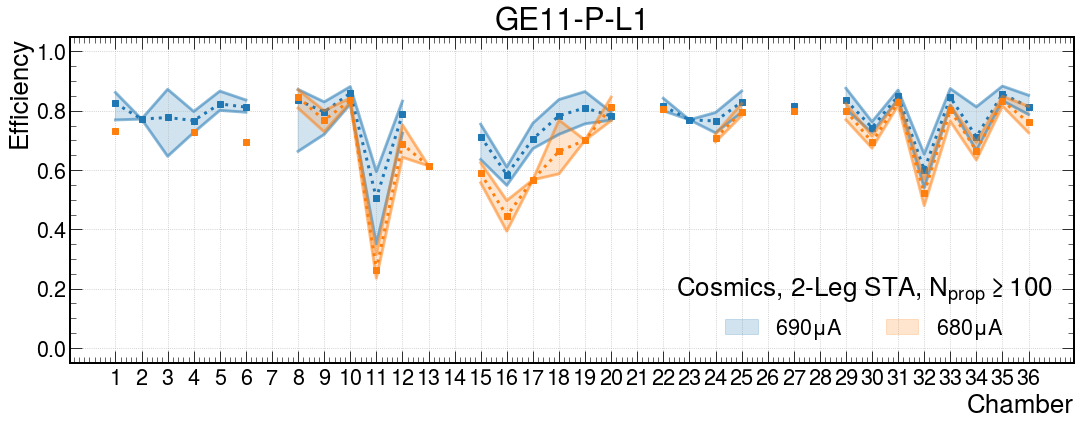

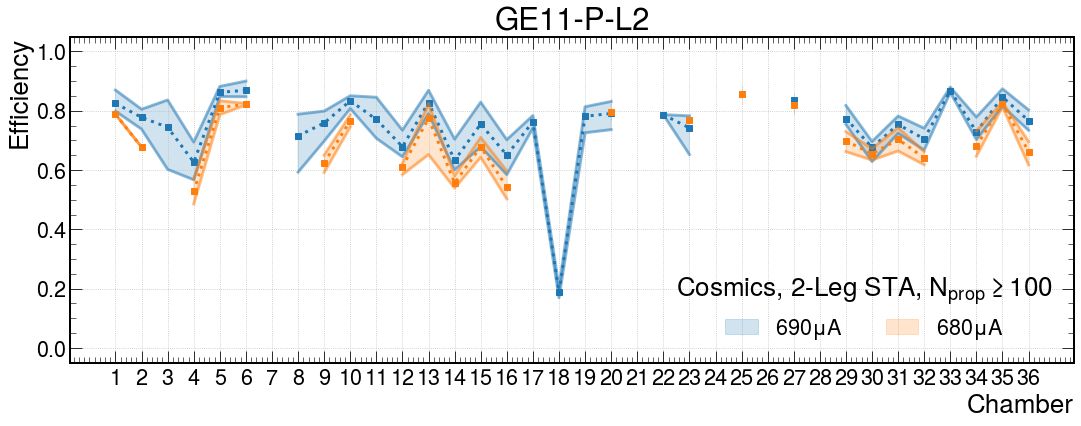

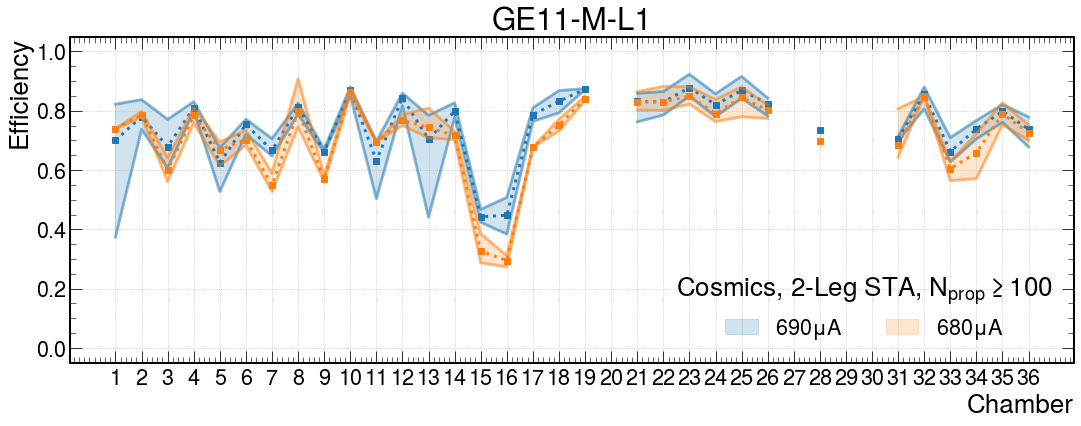

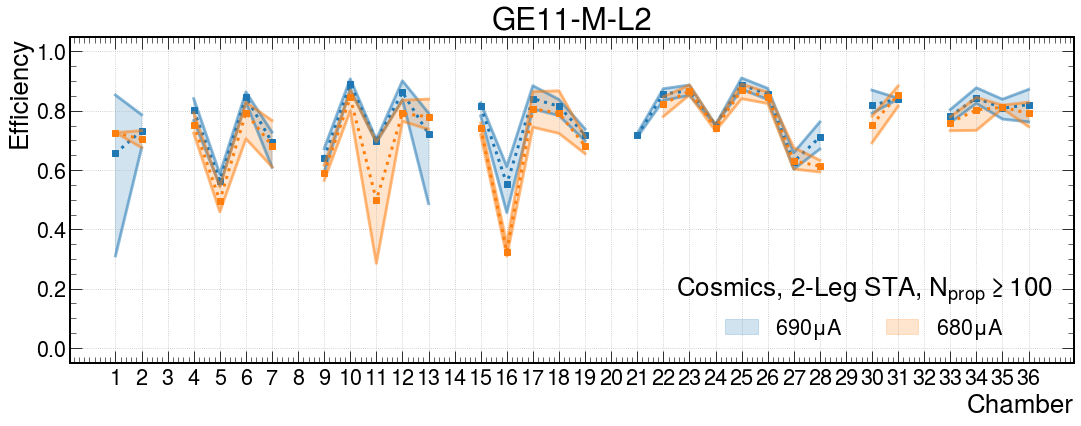

In [13]:
for region in [1, -1]:
    for layer in [1, 2]:
        fig, ax = plt.subplots(figsize=(18, 6), nrows=1)

        data = df[(df.region == region) & (df.layer == layer)]

        for hv, color in hv_color_list:
            plot_fill_between(data[data.hv == hv], label=f"{hv}$\mu$A", color=color, ax=ax)

        _ = ax.set_xticks(range(1, NUM_CHAMBERS + 1))

        title = f"GE11-{'P' if region > 0 else 'M'}-L{layer}"
        ax.set_title(title)
        
        ax.set_xlabel("Chamber")
        ax.set_ylabel("Efficiency")

        legend_title = f"{data_path.stem}, 2-Leg STA, $N_{{prop}} \geq ${min_propagations}"
        ax.legend(title=legend_title, ncol=2, loc='lower right')

        ax.grid()
        ax.set_ylim(-0.05, 1.05)
        
        plot_name = f"{data_path.stem}_{title}_NumPropCut-{min_propagations}"
        plot_path = plot_dir.joinpath(plot_name).with_suffix(".png")

        fig.savefig(plot_path, bbox_inches="tight")